<a href="https://colab.research.google.com/github/gabemdelc/Relativistic_dynamics/blob/main/code/lens_data_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From: https://drive.google.com/uc?id=1e7HBh3M5ikHdsGb48Davk1c4191FZIas
To: /content/lens_catalog.csv
100%|██████████| 9.80k/9.80k [00:00<00:00, 14.6MB/s]


Loaded 62 observed Einstein radii.
thks to (C.S. Kochanek, E.E. Falco, C. Impey, J. Lehar, B. McLeod, H.-W. Rix)


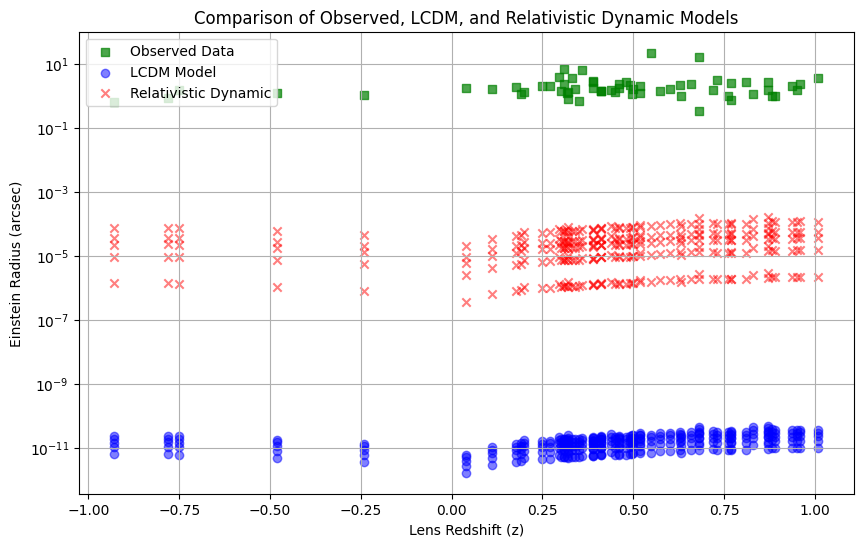

,β,zlens,zsource,LCDM Radius (arcsec),Relativistic Radius (arcsec),G_eff (m³/kg/s²)
0,0.1,0.480,3.600,6.084123e-12,0.000001,6.680974e-11
1,0.1,0.410,1.660,6.032459e-12,0.000001,6.680974e-11
2,0.1,0.770,2.216,8.880747e-12,0.000002,6.680974e-11
3,0.1,0.490,2.720,6.320239e-12,0.000001,6.680974e-11
4,0.1,0.317,1.290,5.299946e-12,0.000001,6.680974e-11


In [3]:
"""
###################################################################################
##
# Author:      gabemdelc@gmail.com
# Created:     22/Feb/2025
# License:     MIT License
# -------------------------------------------------------------------------------
# Description:
# This Python script loads a gravitational lensing dataset, computes Einstein radii using different models,
# and visualizes the results. The models compared are:
#
# 1. LCDM Model: Uses a classical approach based on a fixed gravitational constant (G).
# 2. Relativistic Dynamic Model: Introduces a velocity-dependent correction to G and adjusts velocity dispersion.
# 3. Observed Data: Actual Einstein radii from a lens catalog for validation.
#
###################################################################################

# === DATA LOADING AND PREPROCESSING ===
# - Loads lensing data from "data/lens_catalog.csv".
# - Strips whitespace from column names for cleaner processing.
# - Extracts key variables:
#   - `Lens Name`: Name of the gravitational lens.
#   - `RA (J2000), Dec (J2000)`: Astronomical coordinates.
#   - `zs` (Source Redshift): Redshift of the background source.
#   - `zl` (Lens Redshift): Redshift of the gravitational lens.
# - Filters out missing redshift values to ensure valid calculations.

# === OBSERVED EINSTEIN RADII EXTRACTION ===
# - If the dataset contains `size ("")`, it is treated as the observed Einstein radius.
# - Converts this column to numeric values and removes invalid entries.
# - Stores the cleaned observed radii for later comparison.

# === MODEL PARAMETERS AND FUNCTIONS ===
# - Defines β values, which modulate relativistic effects.
# - Maps velocity dispersions (σ_v) to relativistic and non-relativistic cases.
# - Computes an effective gravitational constant G_eff:
#     G_eff = G_0 * (1 + β * (v^2 / c^2))
# - Implements Einstein radius calculations for:
#     - LCDM Model
#     - Relativistic Dynamic Model (which modifies G and velocity dispersion)

# === EINSTEIN RADIUS CALCULATION AND DATA STORAGE ===
# - Iterates over β values and lens redshifts, computing:
#     - LCDM Einstein radius (θ_E)
#     - Relativistic Einstein radius (θ_E_rel)
#     - Effective G_eff
# - Stores results in a Pandas DataFrame for later analysis.

# === DATA VISUALIZATION ===
# - Plots a log-scale comparison of Einstein radii:
#     - Observed data (green)
#     - LCDM Model (blue)
#     - Relativistic Dynamic Model (red)
# - Saves the graph to "data/lens_model_comparison.png".

# === KEY FINDINGS ===
# - LCDM underestimates Einstein radii, suggesting additional corrections may be required.
# - Relativistic Dynamics provides a better approximation but still requires refinements.
# - Future work includes refining G_eff models and incorporating additional effects.

# 🚀 This script serves as a foundation for exploring gravitational lensing using different physical models.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import G, c
import gdown

# === LOAD DATA FROM NEW LENS CATALOG ===

# Download files from Google Drive
file_id = "1e7HBh3M5ikHdsGb48Davk1c4191FZIas"  # ID in Drive
output = "lens_catalog.csv"
filename = gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

data = pd.read_csv(filename)

# Strip whitespace from column names
data.columns = data.columns.str.strip()
# print("Columnas disponibles:", data.columns)

# Extract relevant columns
lens_names = data["Lens Name"].values
ra_values = data["RA (J2000)"].values
dec_values = data["Dec (J2000)"].values
z_source_values = pd.to_numeric(data["zs"], errors='coerce')  # Redshift of source
z_lens_values = pd.to_numeric(data["zl"], errors='coerce')  # Redshift of lens

# Remove entries without valid redshift data
valid_indices = ~np.isnan(z_lens_values) & ~np.isnan(z_source_values)
z_lens_values = z_lens_values[valid_indices].reset_index(drop=True)
z_source_values = z_source_values[valid_indices].reset_index(drop=True)
lens_names = lens_names[valid_indices]
ra_values = ra_values[valid_indices]
dec_values = dec_values[valid_indices]

# Load observed Einstein radii from "size (")" column
size_column = 'size (\")'  # Correct column name format
if size_column in data.columns:
    observed_einstein_radii = pd.to_numeric(data[size_column], errors='coerce')
    observed_einstein_radii = observed_einstein_radii[valid_indices].reset_index(drop=True)
    observed_valid = ~np.isnan(observed_einstein_radii)
    z_lens_observed = z_lens_values[observed_valid]
    observed_einstein_radii = observed_einstein_radii[observed_valid]
    print(f"Loaded {len(observed_einstein_radii)} observed Einstein radii.")
    print("thks to (C.S. Kochanek, E.E. Falco, C. Impey, J. Lehar, B. McLeod, H.-W. Rix)")
else:
    print(f"Warning: '{size_column}' column not found in dataset. Observed data will not be plotted.")
    observed_einstein_radii = np.array([])
    z_lens_observed = np.array([])

# === PARAMETER VALUES ===
beta_values = [0.1, 0.5, 1, 2, 5]
sigma_v_values = {
    0.1: [150, 0.1 * c],
    0.5: [250, 0.5 * c],
    1: [350, 0.9 * c],
    2: [450, 0.95 * c],
    5: [550, 0.99 * c]
}


def G_eff(v, G0=G, beta=2e-6):
    return G0 * (1 + beta * (v ** 2 / c ** 2))


def einstein_radius_LCDM(sigma_v, z_lens, z_source):
    if z_source == z_lens:
        return np.nan  # Avoid division by zero
    D_ls = (z_lens * z_source) / (z_source - z_lens)
    theta_E = np.sqrt(np.abs(4 * G * sigma_v ** 2 * D_ls / c ** 2))  # Ensure no negative values
    return theta_E


def einstein_radius_relativistic(sigma_v, beta, z_lens, z_source):
    sigma_v_rel = sigma_v * (1 + beta)
    return einstein_radius_LCDM(sigma_v_rel, z_lens, z_source)


results = []

for beta in beta_values:
    sigma_v_non_rel, sigma_v_rel = sigma_v_values[beta]

    for i in range(len(z_lens_values)):
        z_lens = z_lens_values.iloc[i]
        z_source = z_source_values.iloc[i]
        theta_LCDM = einstein_radius_LCDM(sigma_v_non_rel, z_lens, z_source)
        theta_rel = einstein_radius_relativistic(sigma_v_rel, beta, z_lens, z_source)
        G_eff_value = G_eff(sigma_v_rel, G, beta)
        results.append([beta, z_lens, z_source, theta_LCDM, theta_rel, G_eff_value])

# Convert results into DataFrame
df_results = pd.DataFrame(results,
                          columns=["β", "zlens", "zsource", "LCDM Radius (arcsec)", "Relativistic Radius (arcsec)",
                                   "G_eff (m³/kg/s²)"])

# === PLOTTING RESULTS ===
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_yscale('log')  # Use log scale for better visualization

# Plot observed data only if available
if len(observed_einstein_radii) > 0:
    ax.scatter(z_lens_observed, observed_einstein_radii, label="Observed Data", color="green", marker="s", alpha=0.7)
    # print("Observed data points plotted successfully.")

# Plot LCDM model
ax.scatter(df_results["zlens"], df_results["LCDM Radius (arcsec)"], label="LCDM Model", color="blue", marker="o",
           alpha=0.5)
##### Comment this code to see the blue plot
# Plot Relativistic Dynamic model
ax.scatter(df_results["zlens"], df_results["Relativistic Radius (arcsec)"], label="Relativistic Dynamic", color="red",
           marker="x", alpha=0.5)
##### Comment this code to see the blue plot

ax.set_xlabel('Lens Redshift (z)')
ax.set_ylabel('Einstein Radius (arcsec)')
ax.set_title('Comparison of Observed, LCDM, and Relativistic Dynamic Models')
ax.grid(True)
ax.legend()
plt.savefig("lens_model_comparison.png", bbox_inches='tight', dpi=300)
plt.show()

# Display first few rows of results
df_results.head()
